In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import celeri
import addict
import os
from tqdm import tqdm
from celeri.celeri import get_okada_displacements

In [3]:
try:
    already_changed_directory  # type: ignore
except NameError:
    os.chdir("..")
    already_changed_directory = True

In [4]:
command_file_name = "./tests/test_western_north_america_command.json"

command = celeri.get_command(command_file_name)
# celeri.create_output_folder(command)
# logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

# Get all elastic operators for segments and TDEs
command.reuse_elastic = 0

2025-05-29 22:25:03.251 | INFO     | celeri.celeri:read_data:441 - Reading data files
2025-05-29 22:25:03.258 | SUCCESS  | celeri.celeri:read_data:445 - Read: ./tests/test_western_north_america_segment.csv
2025-05-29 22:25:03.261 | SUCCESS  | celeri.celeri:read_data:450 - Read: ./tests/test_western_north_america_block.csv
2025-05-29 22:25:03.261 | SUCCESS  | celeri.celeri:read_data:457 - Read: ./tests/test_western_north_america_mesh_parameters.json


2025-05-29 22:25:03.358 | SUCCESS  | celeri.celeri:read_mesh:436 - Read: ./tests/test_western_north_america_cascadia.msh
2025-05-29 22:25:03.376 | SUCCESS  | celeri.celeri:read_data:525 - Read: ./tests/test_western_north_america_station.csv
2025-05-29 22:25:03.377 | INFO     | celeri.celeri:read_data:540 - No mogi_file_name
2025-05-29 22:25:03.378 | INFO     | celeri.celeri:read_data:562 - No sar_file_name


In [5]:
i = 116  # segment
slip_type = "strike"
station_index = 0

print(f"""
{segment.lon1[i]=}
{segment.lat1[i]=}
{segment.lon2[i]=}
{segment.lat2[i]=}
{segment.locking_depth[i]=}
{segment.burial_depth[i]=}
{segment.dip[i]=}
{segment.azimuth[i]=}
{command.material_lambda=}
{command.material_mu=}
{station.lon[station_index]=}
{station.lat[station_index]=}
""")

def demonstrate_glitch(algorithm, delta_lon=0.0, delta_lat=0.0, triangulation="/"):
    u_east, u_north, u_up = get_okada_displacements(
        segment.lon1[i],
        segment.lat1[i],
        segment.lon2[i],
        segment.lat2[i],
        segment.locking_depth[i],
        segment.burial_depth[i],
        segment.dip[i],
        segment.azimuth[i],
        command.material_lambda,
        command.material_mu,
        1 if slip_type == "strike" else 0,
        1 if slip_type == "dip" else 0,
        1 if slip_type == "tensile" else 0,
        np.array([station.lon[station_index]+delta_lon]),
        np.array([station.lat[station_index]+delta_lat]),
        algorithm=algorithm,
        triangulation=triangulation,  # type: ignore
    )
    return u_north[0]

for triangulation in ["/", "\\", "V"]:
    print(f"{triangulation}: {demonstrate_glitch("cutde", triangulation=triangulation)=}")


segment.lon1[i]=np.float64(241.493)
segment.lat1[i]=np.float64(34.701)
segment.lon2[i]=np.float64(241.498)
segment.lat2[i]=np.float64(34.699)
segment.locking_depth[i]=np.float64(15.0)
segment.burial_depth[i]=np.int64(0)
segment.dip[i]=np.float64(90.0)
segment.azimuth[i]=np.float64(115.84071186322635)
command.material_lambda=30000000000
command.material_mu=30000000000
station.lon[station_index]=np.float64(183.434)
station.lat[station_index]=np.float64(-43.956)

/: demonstrate_glitch("cutde", triangulation=triangulation)=np.float64(1.4891949729441766e-09)
\: demonstrate_glitch("cutde", triangulation=triangulation)=np.float64(1.48920799469669e-09)
V: demonstrate_glitch("cutde", triangulation=triangulation)=np.float64(1.491291538583238e-09)


100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


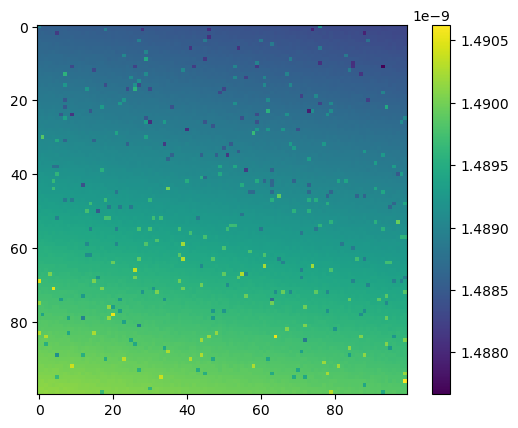

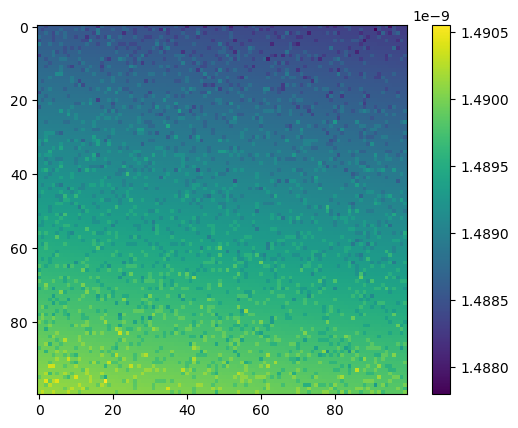

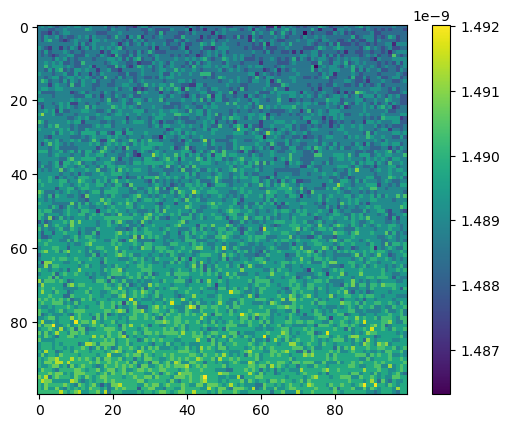

In [6]:
hypothesis_value = 0
x = np.linspace(-0.01, 0.01, 100)
y = np.linspace(-0.01, 0.01, 100)
residual_slash = np.array(
    [
        [
            demonstrate_glitch("cutde", delta_lon=x0, delta_lat=y0) - hypothesis_value
            for x0 in x
        ]
        for y0 in tqdm(y)
    ]
)
residual_backslash = np.array(
    [
        [
            demonstrate_glitch("cutde", delta_lon=x0, delta_lat=y0, triangulation="\\") - hypothesis_value
            for x0 in x
        ]
        for y0 in tqdm(y)
    ]
)
residual_v = np.array(
    [
        [
            demonstrate_glitch("cutde", delta_lon=x0, delta_lat=y0, triangulation="V") - hypothesis_value
            for x0 in x
        ]
        for y0 in tqdm(y)
    ]
)

# Plot rasters of each residual
plt.imshow(residual_slash, cmap="viridis")
plt.colorbar()
plt.show()

plt.imshow(residual_backslash, cmap="viridis")
plt.colorbar()
plt.show()

plt.imshow(residual_v, cmap="viridis")
plt.colorbar()
plt.show()
